In [17]:
import kwant
import numpy as np
import matplotlib.pyplot as plt

import tinyarray

sigma_0 = tinyarray.array([[1, 0], [0, 1]])
sigma_x = tinyarray.array([[0, 1], [1, 0]])
sigma_y = tinyarray.array([[0, -1j], [1j, 0]])
sigma_z = tinyarray.array([[1, 0], [0, -1]])


params=dict(e_z=0.5, alpha=1.5,t=1. )
    
L = 51
W = 26
    
def make_system(params=dict(e_z=0., alpha=0,t=0.),L=51,W=51):
    
    
    
    lat  = kwant.lattice.square(norbs=2)
    syst = kwant.Builder()
    
    def onsite(site,t,e_z):
        (x, y) = site.pos
        return 4 * t* sigma_0 + e_z * sigma_z
    
    def hopping(sitei, sitej,t,alpha):
        xt, yt = sitei.pos
        xs, ys = sitej.pos
        
        t0=-t * sigma_0 
        
        if(xt-xs==1): #hopping in x direction
            t1=1j * alpha * sigma_y / 2
        if(yt-ys==1):
            t1=-1j * alpha * sigma_x / 2
        
        return t0+t1
    
    
    def onsite_L(site,t,e_z):
        (x, y) = site.pos
        
        return 4 * t* sigma_0 + e_z * sigma_z
    
    
    def hopping_L(sitei, sitej,t,alpha):
        
        xt, yt = sitei.pos
        xs, ys = sitej.pos
        
        t0=-t * sigma_0
        
        if(xt-xs==1): #hopping in x direction
            t1=1j * alpha * sigma_y / 2
        if(yt-ys==1):
            t1=-1j * alpha * sigma_x / 2
        
        return t0+t1
    
    def central_region(pos):
        x, y = pos
        return (x < L and x>=0 and y < W and y>=0)
    
    syst[lat.shape(central_region, (0, 0))] = onsite
    syst[lat.neighbors()] = hopping
    
    def lead_shape(pos):
        x, y = pos
        return y < W and y>=0


    
    lead = kwant.Builder(kwant.TranslationalSymmetry((1, 0)))
    lead[lat.shape(lead_shape, (1,0))] = onsite_L
    lead[lat.neighbors()] = hopping_L


    # lead2=lead.finalized()
    # kwant.plotter.bands(lead2, show=False)
    # plt.xlabel("momentum [(lattice constant)^-1]")
    # plt.ylabel("energy [t]")
    # plt.ylim(-0.6,2)
    # plt.xlim(-1.5,1.5)
    # plt.show()
    

    #### Attach the leads and return the finalized system. ####
    syst.attach_lead(lead)
    syst.attach_lead(lead.reversed())

    return syst

In [18]:
   def plot_conductance(syst, energies,params, it=-1):
    # Compute conductance
    data = []
    for energy in energies:
        smatrix = kwant.smatrix(syst, energy,params=params)
        data.append(smatrix.transmission(1, 0))
    
    
    e_z=params["e_z"]
    alpha=params["alpha"]

    
    if it==-1:
        title="C_Ez= {0:.3g}".format(e_z)+"_Alpha= {0:.3g}".format(alpha)
    elif it>-1:
        title=str(it)+"_C_Ez= {0:.3g}".format(e_z)+"_Alpha= {0:.3g}".format(alpha)
        
    plt.figure()
   
    title2=title+".png"
    plt.title(title)
    
    plt.plot(energies, data)
    plt.xlabel("energy [t]")
    plt.ylabel("conductance [e^2/h]")
    plt.savefig(title2)
    

In [19]:
def plot_density(sys,ener,params, it=-1):
    
    wf = kwant.wave_function(sys, energy=ener,params=params)
    
    t=np.shape(wf(0))
    nwf=np.zeros(np.shape(wf(0)[0][::2]),dtype=float)
    
    
    for i in range(min(t[0],25)):

        psi=wf(0)[i]
        up, down = psi[::2], psi[1::2]
        up2=(np.abs(up))**2
        nwf+=up2
    
    
    f= nwf
    
    e_z=params["e_z"]
    alpha=params["alpha"]

    
    if it==-1:
        title="M_Ez= {0:.3g}".format(e_z)+"_Alpha= {0:.3g}".format(alpha)+"_E= {0:.3g}".format(ener)
    elif it>-1:
        title=str(it)+"_M_Ez= {0:.3g}".format(e_z)+"_Alpha= {0:.3g}".format(alpha)+"_E= {0:.3g}".format(ener)
        
    plt.title(title)    
    title2=title+".png"
    kwant.plotter.map(sys, f,method='linear',vmax=max(nwf),vmin=0,show=False,file=title2)
    
    plt.show()
    
    plt.close()


In [20]:
def plot_bands(W, params=dict(e_z=0.0, alpha=0.0, t=0.0)):
    # Compute conductance
    
    e_z=params["e_z"]
    alpha=params["alpha"]
    t=params["t"]

    lat   = kwant.lattice.square(norbs=2)
    def onsite_L(site,t=t,e_z=e_z):
        (x, y) = site.pos
        
        return 4 * t* sigma_0 + e_z * sigma_z
    
    
    def hopping_L(sitei, sitej,t=t,alpha=alpha):
        
        xt, yt = sitei.pos
        xs, ys = sitej.pos
        
        t0=-t * sigma_0
        
        if(xt-xs==1): #hopping in x direction
            t1=1j * alpha * sigma_y / 2
        if(yt-ys==1):
            t1=-1j * alpha * sigma_x / 2
        
        return t0+t1
    
    def lead_shape(pos):
        x, y = pos
        return y < W and y>=0
    

    
    lead = kwant.Builder(kwant.TranslationalSymmetry((1, 0)))
    lead[lat.shape(lead_shape, (1,0))] = onsite_L
    lead[lat.neighbors()] = hopping_L
    

    lead2=lead.finalized()
    kwant.plotter.bands(lead2, show=False)
    plt.xlabel("momentum [(lattice constant)^-1]")
    plt.ylabel("energy [t]")
    
    e_z=params["e_z"]
    alpha=params["alpha"]

    
    title="M_Ez= {0:.3g}".format(e_z)+"_Alpha= {0:.3g}".format(alpha)
    
    
    plt.title(title)
    plt.savefig("b_"+title+".png")
    plt.show()


In [21]:
def main(params,L,W):
    syst = make_system(L=L,W=W)

    # Check that the system looks as intended.
    kwant.plot(syst)

    # Finalize the system.
    syst = syst.finalized()
    
    
    #We should see non-monotonic conductance steps.
    # plot_conductance(syst, energies=[0.005 * i - 0.15 for i in range(100)],params=params)
    # params["alpha"]=0
    plot_bands(W,params)
    E=np.linspace(-0.4,1.2,350)
    plot_conductance(syst, energies=E,params=params)
    
    E_M=[0.1,0.3,0.5,0.8]
    
    
    for i in E_M:
       plot_density(syst,i,params,it=1)
       

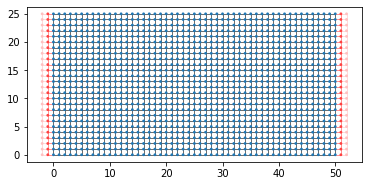

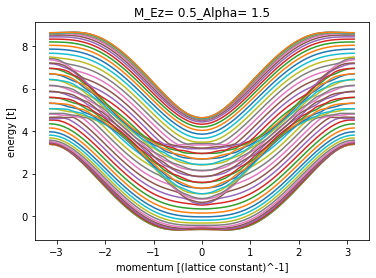

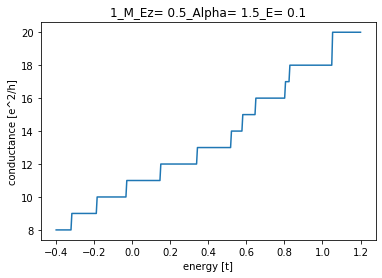

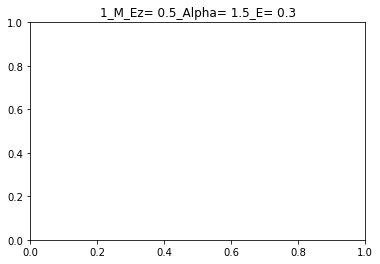

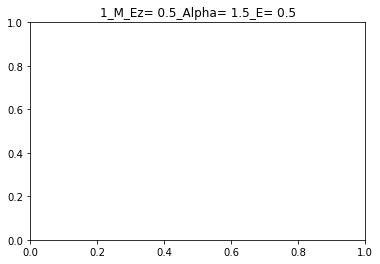

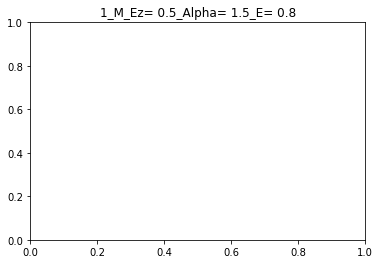

In [22]:
main(params=params,L=L,W=W)